In [1]:
import torch
import requests
import numpy as np
import supervision as sv
from PIL import Image
from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation
from accelerate import Accelerator

In [2]:
device = Accelerator().device


In [3]:
url = "https://www.fcbarcelona.com/fcbarcelona/photo/2021/01/31/3c55a19f-dfc1-4451-885e-afd14e890a11/mini_2021-01-31-BARCELONA-ATHLETIC-BILBAOI-30.JPG"
image = Image.open(requests.get(url, stream=True).raw)

In [4]:
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

In [5]:
inputs = person_image_processor(images=image, return_tensors="pt").to(person_model.device)

with torch.no_grad():
    outputs = person_model(**inputs)

In [6]:
results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]

In [7]:
# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
person_boxes = person_boxes.cpu().numpy()

In [8]:
# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

In [9]:
# Detect keypoints for each person found
image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model(**inputs)

preprocessor_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

In [10]:
pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes])
image_pose_result = pose_results[0]

xy = torch.stack([pose_result['keypoints'] for pose_result in image_pose_result]).cpu().numpy()
scores = torch.stack([pose_result['scores'] for pose_result in image_pose_result]).cpu().numpy()


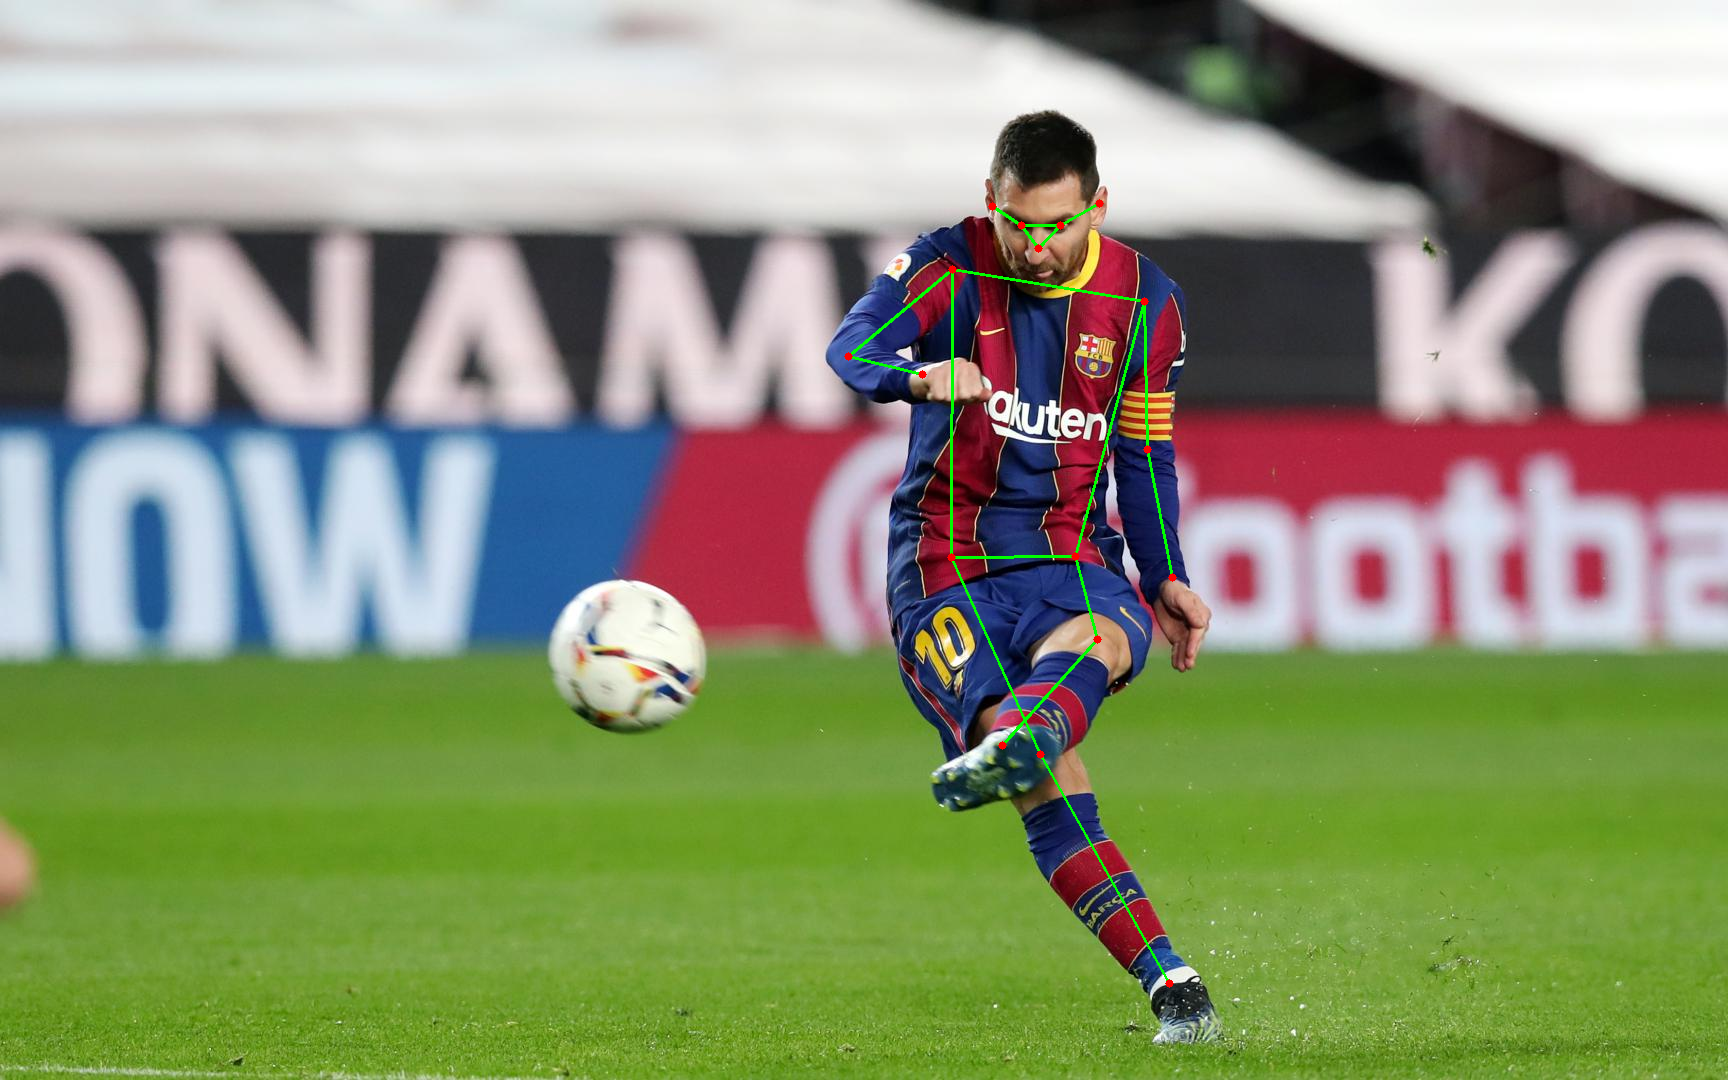

In [12]:
key_points = sv.KeyPoints(
    xy=xy, confidence=scores, 
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.GREEN,
    thickness=2
)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.RED,
    radius=4
)
annotated_frame = edge_annotator.annotate(
    scene=image.copy(),
    key_points=key_points
)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points
)
annotated_frame